In [30]:
from openai import OpenAI
import os, json
import numpy as np
from tqdm import tqdm
os.environ["OPENAI_API_KEY"] = 'api-key'
client = OpenAI()

def get_response(prompt):
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ],
      temperature=0.0,
      max_tokens=2048,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      response_format={
        "type": "text"
      }
    )
    return response.choices[0].message.content

In [2]:
def construct_prompt(gold_concepts: dict, generated_concepts_str: str) -> str:
    '''Construct a prompt asking if each gold concept is present in the generated concepts (to eval recall)'''
    gold_concept_str = ''
    for n, concept in gold_concepts.items():
        gold_concept_str += f"{n}. {concept}\n"
      
    prompt = f"""First, I will give you a list of main concepts. Then, I will give you a numbered list of candidate concepts. For each candidate concept, indicate whether it is supported by the list of main concepts. If it is supported, provide the span of text from the main concepts that support your answer; otherwise, provide an explanation of why it is not supported. Based on your explanation, predict “yes” or “no” for each candidate concept. Output your response by numbering the candidate concepts in the order they are presented.
Provide output in the following format exactly:
[
{{"MC": 1, "span": "explanation", "is_supported": "yes" or "no"}},
{{"MC": 2, "span": "explanation", "is_supported": "yes" or "no"}},
...
]

Main Concepts:
{generated_concepts_str}

Candidate Concepts:
{gold_concept_str}

Only provide the output in the specified format and nothing else (e.g., introductory texts, explanations, or reasons).
"""
    return prompt

def parse_llm_eval(response: str, gold_concepts: dict) -> dict:
    
    cleaned_resp = response.strip('```json').strip('```').strip()
    parsed_resp = json.loads(cleaned_resp)

    gold_concepts_coverage = {
        item["MC"]: 1 if item["is_supported"] == "yes" else 0
        for item in parsed_resp
    }
    
    assert len(gold_concepts_coverage) == len(gold_concepts), f"Response does not cover all gold concepts: {gold_concepts_coverage}"
    return gold_concepts_coverage

In [3]:
def get_yield(sentences):
    num_toks = 0
    for s in sentences:
        num_toks+=len(s.split())
    return num_toks

In [4]:
def get_main_concepts(stimuli_name: str) -> dict:
    with open('../data/BATS/goldMCs/' + stimuli_name + '.json', 'r') as f:
        concepts = json.load(f)
    return concepts

In [5]:
vs_stimuli = ['MarcusYam', 'SylviaEarle', 'NaomiDeLaRosa', 'RobinSteinberg']
sd_stimuli = ['AuntMother', 'Ferguson', 'Sept11', 'NoHandbook']
list_of_stimuli = sd_stimuli+vs_stimuli

stimuli2nummc = {'AuntMother':7,\
                 'Ferguson':10,\
                 'Sept11':12,\
                 'NoHandbook':11,\
                 'MarcusYam':11,\
                 'SylviaEarle':8,\
                 'NaomiDeLaRosa':8,\
                 'RobinSteinberg':7}

### evaluate with clustering

In [ ]:
import pickle 
with open('../MCGenerator/clustering_results/bats/deduplicated_mcs_clustering_run2.pickle', 'rb') as f:
    mcs_per_stimuli = pickle.load(f)
    
    
results = {}
for stimuli in tqdm(list_of_stimuli):
    gold_concepts = get_main_concepts(stimuli)
    mcs_per_delta = mcs_per_stimuli[stimuli]
    
    results[stimuli] = {}
    for delta in mcs_per_delta:
        mc_representatives = mcs_per_delta[delta]['closest_examples']

        eval_prompt = construct_prompt(gold_concepts, "\n".join(mc_representatives))
        response = get_response(eval_prompt)

        gold_coverage = parse_llm_eval(response, gold_concepts)
        recall = sum(gold_coverage.values()) / len(gold_coverage)

        results[stimuli][delta] = {'recall':recall,\
                                   'gold_coverage': gold_coverage,\
                                   'mc_representatives': mc_representatives,\
                                   'eval_prompt': eval_prompt,\
                                   'gold_concepts': gold_concepts,\
                                   'response': response,\
                                   'yield_num_toks':get_yield(mc_representatives),\
                                   'yield_num_mcs':len(mc_representatives),\
                                  }

In [9]:
import pickle 
# with open('../MCGenerator/clustering_results/results/results_clustering_run2_evaluator_run1.pickle', 'wb') as f:
#     pickle.dump(results, f)

with open('../MCGenerator/clustering_results/bats/results_clustering_run2_evaluator_run1.pickle', 'rb') as f:
    results = pickle.load(f)

### evaluate union (with decomp)

In [12]:
def load_jsonl(path):
    data=[]
    with open(path, 'r', encoding='utf-8') as reader:
        for line in reader:
            data.append(json.loads(line))
    return data

In [16]:
generated_concepts_dir = '../MCGenerator/Responses/zero_shot/llama3/original_narrative_input/monte-carlo-same-temp/'

stimuli2mcs = {}
for prompt_name in os.listdir(generated_concepts_dir):
    if '.ipynb_checkpoints' in prompt_name: continue
    data = load_jsonl(generated_concepts_dir+'/'+prompt_name.split('/')[-1])
    for r in data:
        if r['Stimuli'] not in stimuli2mcs:
            stimuli2mcs[r['Stimuli']] = r['decomposed_mcs']
        else:
            stimuli2mcs[r['Stimuli']].extend(r['decomposed_mcs'])

In [36]:
results = {}
for stimuli in tqdm(list_of_stimuli):
    gold_concepts = get_main_concepts(stimuli)
    mcs = stimuli2mcs[stimuli] #all mcs for this stimuli
    
    eval_prompt = construct_prompt(gold_concepts, "\n".join(mcs))
    response = get_response(eval_prompt)
    gold_coverage = parse_llm_eval(response, gold_concepts)
    recall = sum(gold_coverage.values()) / len(gold_coverage)
    
    results[stimuli] = {'recall':recall,\
                       'gold_coverage': gold_coverage,\
                       'eval_prompt': eval_prompt,\
                       'gold_concepts': gold_concepts,\
                       'response': response,\
                       'yield_num_toks':get_yield(mcs),\
                       'yield_num_mcs':len(mcs),\
                      }

In [54]:
import pickle 

# with open('../MCGenerator/clustering_results/bats/results_without_clustering_with_decomposition.pickle', 'wb') as f:
#     pickle.dump(results, f)

with open('../MCGenerator/clustering_results/bats/results_without_clustering_with_decomposition.pickle', 'rb') as f:
    results = pickle.load(f)
    
recall_without_clustering = []  
yield_num_toks_without_clustering = []
yield_num_mcs_without_clustering = []
for stimuli in tqdm(list_of_stimuli):
    recall_without_clustering.append(results[stimuli]['recall'])
    yield_num_toks_without_clustering.append(results[stimuli]['yield_num_toks'])
    yield_num_mcs_without_clustering.append(results[stimuli]['yield_num_mcs'])
    
np.mean(recall_without_clustering), np.mean(yield_num_toks_without_clustering), np.mean(yield_num_mcs_without_clustering)

100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 67513.95it/s]


(0.8877299783549784, 3109.125, 345.125)

### evaluate union (w/o decomp)

In [ ]:
generated_concepts_dir = '../MCGenerator/Responses/zero_shot/llama3/original_narrative_input/monte-carlo-same-temp/'

stimuli2mcs_without_decomp = {}
for prompt_name in os.listdir(generated_concepts_dir):
    if '.ipynb_checkpoints' in prompt_name: continue
    data = load_jsonl(generated_concepts_dir+'/'+prompt_name.split('/')[-1])
    for r in data:
        if r['Stimuli'] not in stimuli2mcs_without_decomp:
            stimuli2mcs_without_decomp[r['Stimuli']] = [r['response']]
        else:
            stimuli2mcs_without_decomp[r['Stimuli']].extend([r['response']])

results = {}
for stimuli in tqdm(list_of_stimuli):
    gold_concepts = get_main_concepts(stimuli)
    mcs = stimuli2mcs_without_decomp[stimuli] #all mcs for this stimuli
    
    eval_prompt = construct_prompt(gold_concepts, "\n".join(mcs))
    response = get_response(eval_prompt)
    gold_coverage = parse_llm_eval(response, gold_concepts)
    recall = sum(gold_coverage.values()) / len(gold_coverage)
    
    results[stimuli] = {'recall':recall,\
                       'gold_coverage': gold_coverage,\
                       'eval_prompt': eval_prompt,\
                       'gold_concepts': gold_concepts,\
                       'response': response,\
                       'yield_num_toks':get_yield(mcs),\
                       'yield_num_mcs':len(mcs),\
                      }

In [ ]:
import pickle 

# with open('../MCGenerator/clustering_results/bats/results_without_clustering_without_decomposition.pickle', 'wb') as f:
#     pickle.dump(results, f)

In [53]:
with open('../MCGenerator/clustering_results/bats/results_without_clustering_without_decomposition.pickle', 'rb') as f:
    results = pickle.load(f)
    
recall_without_clustering = []  
yield_num_toks_without_clustering = []
yield_num_mcs_without_clustering = []
for stimuli in tqdm(list_of_stimuli):
    recall_without_clustering.append(results[stimuli]['recall'])
    yield_num_toks_without_clustering.append(results[stimuli]['yield_num_toks'])
    yield_num_mcs_without_clustering.append(results[stimuli]['yield_num_mcs'])
    
np.mean(recall_without_clustering), np.mean(yield_num_toks_without_clustering), np.mean(yield_num_mcs_without_clustering)

100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 88069.38it/s]


(0.9229572510822511, 2933.625, 15.0)

### evaluate individual prompts (with decomp)

In [24]:
prompt_filenames = os.listdir('../MCGenerator/Prompts/zero_shot/')
prompt_filenames = [p.split('.')[0] for p in prompt_filenames if '.txt' in p]
#prompt_filenames

In [23]:
generated_concepts_dir = '../MCGenerator/Responses/zero_shot/llama3/original_narrative_input/monte-carlo-same-temp/'
file_names = os.listdir(generated_concepts_dir)
for f_name in file_names:
    if '.ipynb_checkpoints' in f_name:
        continue
    d = load_jsonl(generated_concepts_dir+f_name)
    #print(f_name, len(d))

In [28]:
generated_concepts_dir = '../MCGenerator/Responses/zero_shot/llama3/original_narrative_input/monte-carlo-same-temp/'
eval_response_save_dir = './Responses/zero_shot/gpt4o/original_narrative_input/monte-carlo-same-temp-decomposed-mcs/'
file_names = os.listdir(generated_concepts_dir)

for f_name in file_names:
    if '.jsonl' not in f_name: continue
    generated_concepts = load_jsonl(generated_concepts_dir+f_name)
    save_data = []
    for r in tqdm(generated_concepts):
        stimuli = r['Stimuli']
        gold_concepts = get_main_concepts(stimuli)
        
        #generated_concept_str = r['response'] # uncomment to evluate generated MCs w/o decomposition
        
        generated_concept_str =  "\n".join(r['decomposed_mcs'])
        eval_prompt = construct_prompt(gold_concepts, generated_concept_str)
        response = get_response(eval_prompt)
        gold_coverage = parse_llm_eval(response, gold_concepts)
        recall = sum(gold_coverage.values()) / len(gold_coverage)
        yield_ = get_yield_num_toks(generated_concept_str)

        info = {'stimuli': stimuli,
                'mc_prompt_name': f_name, 
                'eval_prompt': eval_prompt,
                'raw_eval_completion': response,
                'gold_coverage': gold_coverage,
                'recall': recall,
                'yield_num_toks': yield_
                }
        save_data.append(info)

    save_jsonl(eval_response_save_dir+f_name, save_data)

In [31]:
for f_name in os.listdir(eval_response_save_dir):
    data = load_jsonl(eval_response_save_dir+f_name)
    mean_recall = np.mean([r['recall'] for r in data if r['recall']==r['recall']])
    mean_yield = np.mean([r['yield_num_toks'] for r in data])
    print(f_name, mean_recall, mean_yield)

five_finger_according_temp_0.67_3.jsonl 0.6470373376623377 732.125
five_finger_according_temp_0.67_2.jsonl 0.6852408008658009 782.0
help_me_understand_temp_0.67_4.jsonl 0.5742559523809524 1436.125
five_finger_according_temp_0.67_1.jsonl 0.7159361471861472 757.875
five_finger_according_temp_0.67_0.jsonl 0.6937635281385282 798.75
7_unit_story_grammar_temp_0.67_4.jsonl 0.592870670995671 923.375
7_unit_story_grammar_temp_0.67_3.jsonl 0.5584415584415585 992.75
help_me_understand_temp_0.67_2.jsonl 0.7068046536796536 1424.25
7_unit_story_grammar_temp_0.67_2.jsonl 0.5876082251082251 1029.5
help_me_understand_temp_0.67_3.jsonl 0.6701975108225108 1464.125
7_unit_story_grammar_temp_0.67_1.jsonl 0.5908820346320347 1049.0
help_me_understand_temp_0.67_0.jsonl 0.6651785714285714 1446.25
five_finger_according_temp_0.67_4.jsonl 0.6730790043290044 701.75
7_unit_story_grammar_temp_0.67_0.jsonl 0.5969832251082251 1033.25
help_me_understand_temp_0.67_1.jsonl 0.7077516233766235 1469.0


### evaluate individual prompts (without decomp)

In [32]:
generated_concepts_dir = '../MCGenerator/Responses/zero_shot/llama3/original_narrative_input/monte-carlo-same-temp/'
eval_response_save_dir = './Responses/zero_shot/gpt4o/original_narrative_input/monte-carlo-same-temp-without-decomposed-mcs/'
file_names = os.listdir(generated_concepts_dir)

for f_name in file_names:
    if '.jsonl' not in f_name: continue
    generated_concepts = load_jsonl(generated_concepts_dir+f_name)
    save_data = []
    for r in tqdm(generated_concepts):
        stimuli = r['Stimuli']
        gold_concepts = get_main_concepts(stimuli)
        
        generated_concept_str = r['response'] 
        
        #generated_concept_str =  "\n".join(r['decomposed_mcs']) 
        eval_prompt = construct_prompt(gold_concepts, generated_concept_str)
        response = get_response(eval_prompt)
        gold_coverage = parse_llm_eval(response, gold_concepts)
        recall = sum(gold_coverage.values()) / len(gold_coverage)
        yield_ = get_yield_num_toks(generated_concept_str)

        info = {'stimuli': stimuli,
                'mc_prompt_name': f_name, 
                'eval_prompt': eval_prompt,
                'raw_eval_completion': response,
                'gold_coverage': gold_coverage,
                'recall': recall,
                'yield_num_toks': yield_
                }
        save_data.append(info)

    save_jsonl(eval_response_save_dir+f_name, save_data)

In [33]:
for f_name in os.listdir(eval_response_save_dir):
    data = load_jsonl(eval_response_save_dir+f_name)
    mean_recall = np.mean([r['recall'] for r in data if r['recall']==r['recall']])
    mean_yield = np.mean([r['yield_num_toks'] for r in data])
    print(f_name, mean_recall, mean_yield)

7_unit_story_grammar_temp_0.67_0.jsonl 0.6315611471861473 1076.375
five_finger_according_temp_0.67_1.jsonl 0.7066558441558441 741.5
7_unit_story_grammar_temp_0.67_1.jsonl 0.6230790043290043 1067.875
five_finger_according_temp_0.67_0.jsonl 0.7492288961038961 771.375
7_unit_story_grammar_temp_0.67_2.jsonl 0.6103354978354978 1065.375
five_finger_according_temp_0.67_3.jsonl 0.6905979437229437 699.75
help_me_understand_temp_0.67_4.jsonl 0.6033279220779221 1252.125
7_unit_story_grammar_temp_0.67_3.jsonl 0.6218885281385281 1042.625
five_finger_according_temp_0.67_2.jsonl 0.6530438311688311 763.5
help_me_understand_temp_0.67_3.jsonl 0.6951569264069264 1287.5
7_unit_story_grammar_temp_0.67_4.jsonl 0.6282873376623377 1001.375
help_me_understand_temp_0.67_2.jsonl 0.6960497835497836 1329.625
five_finger_according_temp_0.67_4.jsonl 0.674025974025974 680.75
help_me_understand_temp_0.67_1.jsonl 0.6521509740259741 1344.5
help_me_understand_temp_0.67_0.jsonl 0.6992694805194806 1265.75


### plot recall-yield trade off 

In [37]:
bounds = {'theoretical union w/ decomp': {'recall': 0.9521780303030303, 'yield_num_toks': 2974.25},\
 'theoretical union w/o decomp': {'recall': 0.9408143939393939, 'yield_num_toks': 2758.25},\
 'empirical union w/ decomp': {'recall': 0.8877299783549784, 'yield_num_toks': 3109.125, 'yield_num_mcs': 345.125},\
 'empirical union w/o decomp': {'recall': 0.9229572510822511, 'yield_num_toks': 2933.625},\
}

In [39]:
import pandas as pd
def get_recall_df(prompt_filenames):
    recall_dict_decomposed = {}
    for prompt_name in prompt_filenames:
        data = load_jsonl(eval_response_save_dir+'/'+prompt_name.split('/')[-1])
        yield_dict = {}
        for r in data:
            yield_dict[r['stimuli']] = r['recall']

        recall_dict_decomposed[prompt_name.split('/')[-1]] = yield_dict

    recall_dict_decomposed = pd.DataFrame(recall_dict_decomposed)
    return recall_dict_decomposed

def get_yield_df(prompt_filenames):
    yield_dict_decomposed = {}
    for prompt_name in prompt_filenames:
        data = load_jsonl(eval_response_save_dir+'/'+prompt_name.split('/')[-1])
        yield_dict = {}
        for r in data:
            yield_dict[r['stimuli']] = r['yield_num_toks']

        yield_dict_decomposed[prompt_name.split('/')[-1]] = yield_dict

    yield_dict_decomposed = pd.DataFrame(yield_dict_decomposed)
    return yield_dict_decomposed

In [40]:
eval_response_save_dir = '../MCEvaluator/Responses/zero_shot/gpt4o/original_narrative_input/monte-carlo-same-temp-decomposed-mcs/'

prompt_filenames = [eval_response_save_dir+f for f in os.listdir(eval_response_save_dir)]
 
recall_dict_decomposed = get_recall_df([p for p in prompt_filenames if 'five' in p])
yield_dict_decomposed = get_yield_df([p for p in prompt_filenames if 'five' in p])
bounds['five finger w/ decomp'] = {'recall': recall_dict_decomposed.mean(axis=0).mean(),\
                                   'yield_num_toks': yield_dict_decomposed.mean(axis=0).mean()}

del recall_dict_decomposed
del yield_dict_decomposed


recall_dict_decomposed = get_recall_df([p for p in prompt_filenames if 'unit' in p])
yield_dict_decomposed = get_yield_df([p for p in prompt_filenames if 'unit' in p])
bounds['7 unit story grammar w/ decomp'] = {'recall': recall_dict_decomposed.mean(axis=0).mean(),\
                                           'yield_num_toks': yield_dict_decomposed.mean(axis=0).mean()}

del recall_dict_decomposed
del yield_dict_decomposed

recall_dict_decomposed = get_recall_df([p for p in prompt_filenames if 'help' in p])
yield_dict_decomposed = get_yield_df([p for p in prompt_filenames if 'help' in p])
bounds['help me understand w/ decomp'] = {'recall': recall_dict_decomposed.mean(axis=0).mean(),\
                                         'yield_num_toks': yield_dict_decomposed.mean(axis=0).mean()}

del recall_dict_decomposed
del yield_dict_decomposed

In [41]:
eval_response_save_dir = '../MCEvaluator/Responses/zero_shot/gpt4o/original_narrative_input/monte-carlo-same-temp-without-decomposed-mcs/'

prompt_filenames = [eval_response_save_dir+f for f in os.listdir(eval_response_save_dir)]
 
recall_dict_decomposed = get_recall_df([p for p in prompt_filenames if 'five' in p])
yield_dict_decomposed = get_yield_df([p for p in prompt_filenames if 'five' in p])
bounds['five finger w/o decomp'] = {'recall': recall_dict_decomposed.mean(axis=0).mean(),\
                                   'yield_num_toks': yield_dict_decomposed.mean(axis=0).mean()}

del recall_dict_decomposed
del yield_dict_decomposed


recall_dict_decomposed = get_recall_df([p for p in prompt_filenames if 'unit' in p])
yield_dict_decomposed = get_yield_df([p for p in prompt_filenames if 'unit' in p])
bounds['7 unit story grammar w/o decomp'] = {'recall': recall_dict_decomposed.mean(axis=0).mean(),\
                                           'yield_num_toks': yield_dict_decomposed.mean(axis=0).mean()}

del recall_dict_decomposed
del yield_dict_decomposed

recall_dict_decomposed = get_recall_df([p for p in prompt_filenames if 'help' in p])
yield_dict_decomposed = get_yield_df([p for p in prompt_filenames if 'help' in p])
bounds['help me understand w/o decomp'] = {'recall': recall_dict_decomposed.mean(axis=0).mean(),\
                                         'yield_num_toks': yield_dict_decomposed.mean(axis=0).mean()}

del recall_dict_decomposed
del yield_dict_decomposed

In [46]:
import pickle 
with open('../MCGenerator/clustering_results/bats/results_clustering_run2_evaluator_run1.pickle', 'rb') as f:
    results = pickle.load(f)
    
from collections import defaultdict
deltas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 5, 10, 15, 20]

# Initialize accumulators for each delta
delta_values = defaultdict(lambda: {'recall': 0, 'yield_num_toks': 0, 'yield_num_mcs': 0, 'count': 0})

# Accumulate data across all stimuli for each delta
for stimuli in results:
    for delta, metrics in results[stimuli].items():
        delta_values[delta]['recall'] += metrics['recall']
        delta_values[delta]['yield_num_toks'] += metrics['yield_num_toks']
        delta_values[delta]['yield_num_mcs'] += metrics['yield_num_mcs']
        delta_values[delta]['count'] += 1

# Compute the average for each delta
averaged_results = {delta: {
    'avg_recall': vals['recall'] / vals['count'],
    'avg_yield_num_toks': vals['yield_num_toks'] / vals['count'],
    'avg_yield_num_mcs': vals['yield_num_mcs'] / vals['count'],
} for delta, vals in delta_values.items()}

# Sort deltas to ensure proper plotting order
sorted_deltas = sorted(averaged_results.keys())
avg_recall = [averaged_results[delta]['avg_recall'] for delta in sorted_deltas]
avg_yield_num_toks = [averaged_results[delta]['avg_yield_num_toks'] for delta in sorted_deltas]
avg_yield_num_mcs = [averaged_results[delta]['avg_yield_num_mcs'] for delta in sorted_deltas]

In [49]:
df = pd.DataFrame()
df['experiment'] = ['clustering']*len(sorted_deltas)
df['delta'] = sorted_deltas
# df['avg_yield_num_mcs'] = avg_yield_num_mcs
df['avg_yield_num_toks'] = avg_yield_num_toks
df['avg_recall'] = avg_recall

for b in bounds:
    new_row = {'experiment': b,\
              'delta': 'n/a',\
              'avg_yield_num_toks': bounds[b]['yield_num_toks'],\
              'avg_recall': bounds[b]['recall']}
    
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df.to_csv('../MCGenerator/clustering_results/bats/data_for_plots.csv', sep='\t')

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


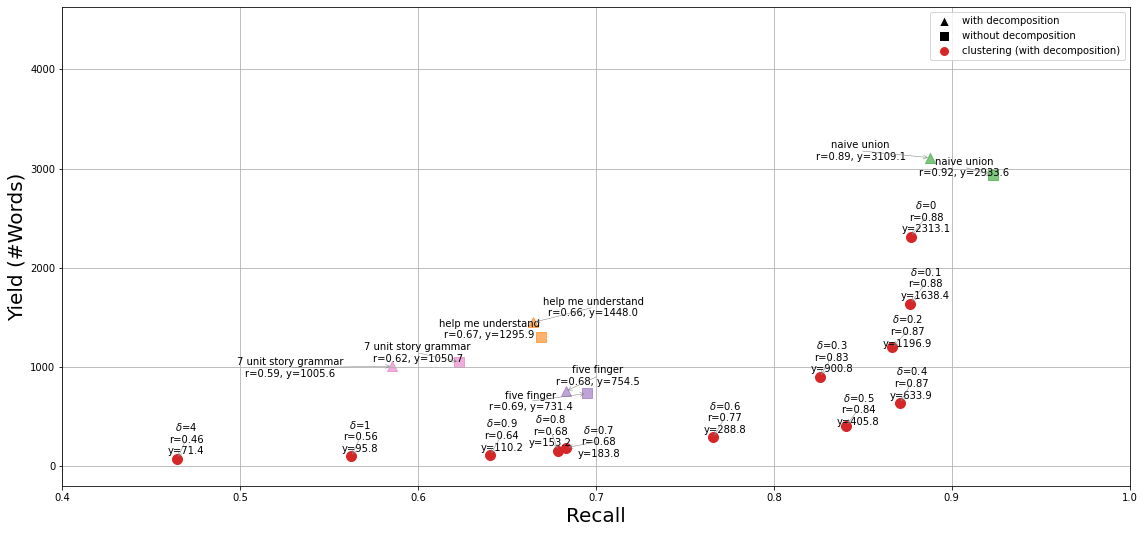

In [50]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


fig, axes = plt.subplots(1, 1, figsize=(16, 8))
axes.scatter(avg_recall[:-3], avg_yield_num_toks[:-3], color='tab:red', s=100, marker='o', label='Main Data')


annotations = []
for label, data in bounds.items():
    if 'theoretical' in label:
        continue
    recall = data['recall']
    yield_toks = data['yield_num_toks']
    
    if 'theoretical' in label:
        color = 'tab:blue'
    elif 'empirical' in label:
        color = 'tab:green'
    elif 'help' in label:
        color = 'tab:orange'  
    elif 'five' in label:
        color = 'tab:purple'  
    elif 'unit' in label:
        color = 'tab:pink'  
    else:
        color = 'tab:gray' 
        
    if 'w/o' in label:
        marker = 's'
    elif 'w/ ' in label:
        marker = '^'
    else:
        marker = 'x'

    # Plot the additional point
    axes.scatter(recall, yield_toks, color=color, s=100, marker=marker, alpha=0.6)

    if label=='empirical union w/ decomp':
        label = 'naive union w/ decomp'
    if label=='empirical union w/o decomp':
        label = 'naive union w/o decomp'
        
    # Add text annotation with the label and recall/yield values
    annotation_text = (
        f"{label.split(' w/')[0]}\n"
        f"r={recall:.2f}, y={yield_toks:.1f}"
    )
    
    
    annotations.append(axes.text(recall, yield_toks, annotation_text, fontsize=11, ha='right'))


for i, delta in enumerate(deltas[:-3]):
    if delta==5:
        delta = 4
    annotation_text = f'$\delta$={delta}\nr={avg_recall[i]:.2f}\ny={avg_yield_num_toks[i]:.1f}'
    annotations.append(axes.text(avg_recall[i], avg_yield_num_toks[i], annotation_text, 
                                 ha='center', va='center', fontsize=12))


def annotate_points(annotations, ax):
    for annotation in annotations:
        annotation.set_fontsize(10)
        annotation.set_ha('right')
        annotation.set_va('bottom')

# Then, before adjust_text
annotate_points(annotations, axes)

adjust_text(annotations, 
            ax=axes, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.2, 1.2),  # Slight expansion to prevent overlap
            force_points=(0.1, 0.25)   # Adjust text movement force
)

# Set axis labels and title
axes.set_xlabel('Recall', fontsize=20)
axes.set_xticks(ticks = np.arange(0.4, 1.1, 0.1), fontsize=20)
axes.set_ylabel('Yield (#Words)', fontsize=20)
# axes.set_title('Recall vs Yield (#Tokens)')
axes.grid(True)


axes.margins(y=0.5)  
axes.set_ylim(bottom=-200) 

plt.subplots_adjust(bottom=0.8) 

legend_elements = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=10, label='with decomposition'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=10, label='without decomposition'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:red', markersize=10, label='clustering (with decomposition)')
]


axes.legend(handles=legend_elements, loc='best')


plt.tight_layout(rect=[0, 0.05, 1, 1])  # Avoid overriding bottom margin

# plt.savefig('./clustering_results/plots/cac_2025.png')